#  Homework 04: KNN for Churn Prediction

## Introduction

This week, we will go more deeply into the churn prediction task introduced in the previous homework. As you already know, churn prediction is one of the most popular use cases of machine learning in business, consisting of detecting customers who are likely to cancel a subscription to a service. Churn can be triggered by better price offers, more interesting packages, bad service experiences or personal situation changes experienced by customers. To timely prevent customers' churn, companies might adopt a machine learning classifier able to predict churn on an individual customer basis, and then use the predictions of this classifier to know when countermeasures (e.g., discounts or special offers) against churn are needed, to prevent the churn event.  

In the previous homework, you were expected to use a range of demographic and basic contract-related features and create five additional behavioral as well as an appropriate evaluation method and performance metric(s) to assess the goodness of your classifier in predicting churn for customers.

In this homework, we ask you again to work on the machine-learning pipeline presented at the end of lecture 4, by instantiating, exploring, and fine-tuning a series of k-Nearest-Neighbors (kNNs) classifiers. Specifically, we will ask you to:

- Experiment with distance matrices and KNN classifiers fed with only demographic features or only behavioral features.
- Experiment with distance matrices and KNN classifiers fed with both demographic and behavioral features. 
- Report, visually, the performance of three fine-tuned KNN classifiers (demographic, tuned), (behavioral, tuned), and (combined, tuned), and discuss.

The focus of this homework is on modelling and not on the quality of features. Therefore, note that there should be **no** need to perform any feature engineering in this homework. You are expected to re-use the features (and possibly a part of the source code) that you have created in homework 3. If you have not submitted homework 3, please do get in touch with the TAs, and they will provide five example behavioral feature to use in this homework.  


## Submission 

The homework is due **Mar 30, 2021 23:59 CET**. The notebook must be pushed to your GitHub classroom repository. 

If you have any questions, feel free to use the Q&A forum in Moodle. 

## Some Instructions 

1. You are allowed to use any built-in Python library. If you want to use an external library, you have to justify it. 
2. Make sure you use the data folder provided in the repository in **read-only** mode. 
3. Please write all your comments in English, and use meaningful variable names in your code. 
4. Your repo should have a single notebook (plus the required data files) in the master branch. 
5. Be sure to hand in a fully-run and evaluated notebook (check the rendered notebook on the GitHub website once you have pushed). 
6. Be sure to provide a textual description of your thoughts, assumptions, solutions, and explanations for your answers, when requested.

## The Data Set

In this homework, you will use the same data set as in homework 3. The `data` folder includes CSV files pertaining to customer's demographic attributes, contract information, and monthly service-related data. 

For the sake of easiness and clarity, in this homework, we will use the convention that:
- features you compute from the **customer.csv** file are referred to as **(pseudo)demographic / demographic features**;
- features you compute from the **phone_usage.csv**, **services.csv**, and **charges.csv** files are referred to as **behavioral features**.

The **target values** are represented by the **churn labels** listed in the **churn.csv** file under the **"Churn" column**.   

Each file is characterized by the following attributes:

**customer.csv**

| Name                   | Description                         |
| ---------------------- | ------------------------------------------------------------ |
| CustomerID | A unique ID that identifies each customer.  | 
| Gender |  The customer’s gender: Male, Female  | 
| SeniorCitizen | Indicates if the customer is 65 or older: 0, 1.  | 
| Partner |  Indicates if the customer is married: Yes, No | 
| Dependents | Indicates if the customer lives with any dependents: Yes, No.  |  
| PaperlessBilling | Indicates if the customer has chosen paperless billing: Yes, No.  | 
| PaymentMethod |  Indicates how the customer pays their bill: Mailed check, Electronic check, Credit card, Bank transfer.  | 

**contract.csv**

| Name                   | Description                         |
| ---------------------- | ------------------------------------------------------------ |
| ContractID |  A unique ID that identifies each contract.  | 
| CustomerID |  A unique ID that identifies each customer.  | 
| Contract |  Indicates the customer’s current contract type: Month-to-Month, One Year, Two Year.  | 
| StartDate |  Start date of the contract. | 

**churn.csv**

| Name                   | Description                         |
| ---------------------- | ------------------------------------------------------------ |
| CustomerID | A unique ID that identifies each customer.   | 
| Churn | 1 = the customer left the company. 0 = the customer remained with the company.  | 

**phone_usage.csv**

| Name                   | Description                         |
| ---------------------- | ------------------------------------------------------------ |
| ContractID | A unique ID that identifies each contract.  | 
| Date | The reference period for the monthly usage indicated by this record for this ContractID.  | 
| MonthlyUsage | Indicates the customer’s monthly usage for the phone.  | 

**services.csv**

| Name                   | Description                         |
| ---------------------- | ------------------------------------------------------------ |
| ContractID | A unique ID that identifies each contract.  | 
| ServiceValue | The specific service value of type Service the contract has. No = the customer does not have that Service.   | 
| Service | A string label identifying a type of service offered by the company: PhoneService, InternetService, MultipleLines, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies.   | 

**charges.csv**

| Name                   | Description                         |
| ---------------------- | ------------------------------------------------------------ |
| ContractID |  A unique ID that identifies each contract. | 
| Date | The billing date for the monthly usage indicated by this record for this ContractID.   | 
| Charge | Indicates the contract’s monthly charge.  | 

In [32]:
### YOUR IMPORT STATEMENTS HERE (please, do not make any imports elsewhere in the notebook) ###

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn import datasets, metrics, model_selection, preprocessing
from sklearn.neighbors import DistanceMetric
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import normalize

In [3]:
# Files with one record per customer / contract
customer = pd.read_csv('./data/customer.csv')
contract = pd.read_csv('./data/contract.csv')
churn = pd.read_csv('./data/churn.csv')

# Files with one record per customer / contract over months
phone_usage = pd.read_csv('./data/phone_usage.csv')
services = pd.read_csv('./data/services.csv')
charges = pd.read_csv('./data/charges.csv')

y = pd.read_csv('./data/churn.csv')

<a id="section1"></a>
## 1  Experiment with KNN classifiers and demographic features
----

In this section, you should:
1. Prepare a feature matrix with only `demographic features` for each customer (one row per customer, features included in the customer.csv file) and compute a `pair-wise distance matrix` across customers, with an appropriate distance measure.
2. To predict the churn target, implement three kNN classifiers and feed them with the created pairwise-distance matrix. Evaluate each kNN classifier by using a `10-fold user-stratified cross-validation` and use `Balanced Accuracy` and `AUC` as performance metrics.
3. Then, re-use and extend the implementation provided in Task 1.2 to fine tune the hyper-parameter k of the kNN classifier. 
4. Report visually `Balanced Accuracy` and `AUC` of (i) the three kNN classifiers implemented in Task 1.2 and (ii) the fine-tuned kNN classifier obtained in Task 1.3, in such a way that they can be easily and appropriately compared. 

<a id="section1.1"></a>
### Task 1.1 

The k-Nearest-Neighbor (kNN) is one of the simplest algorithms for finding patterns in classification problems. 

In this task, to prepare the training data to be fed into the kNN classifier, we ask you to:
- Compute a feature matrix `XD` with one row per customer and one column per **demographic** feature (i.e., **the features included in the customer.csv file**). The cell `XD[i,j]` represents the value of the demographic feature `j` for customer `i`. The shape of the matrix `XD` should be (n_customers, n_demographic_features). 
- Compute a pair-wise distance matrix `DD` with one row per customer and one column per customer. The cell `DD[i,j]` represents the pair-wise distance between the features vectors `XD[i]` and `XD[j]` of customer `i` and customer `j`, respectively. The shape of the matrix `DD` should be (n_customers, n_customers). Make sure to pick an appropriate distance measure.

In [4]:
### YOUR CODE HERE (please, feel free to add extra cells to solve this task, after this first one) ###

X_dem = customer
XD = X_dem.replace({'Female' : 1, 'Male' : 0, 'Yes' : 1, 'No' : 0, 'Mailed check' : 0, 'Electronic check' : 1, 'Credit card (automatic)' : 2,
       'Bank transfer (automatic)' : 3 })
XD = XD.drop({'CustomerID'}, axis = 1)
dist = DistanceMetric.get_metric('hamming')
DD = dist.pairwise(XD)

In [5]:
print(DD)

[[0.         0.66666667 0.66666667 ... 0.5        0.33333333 0.5       ]
 [0.66666667 0.         0.33333333 ... 0.16666667 0.33333333 0.5       ]
 [0.66666667 0.33333333 0.         ... 0.16666667 0.66666667 0.5       ]
 ...
 [0.5        0.16666667 0.16666667 ... 0.         0.5        0.66666667]
 [0.33333333 0.33333333 0.66666667 ... 0.5        0.         0.16666667]
 [0.5        0.5        0.5        ... 0.66666667 0.16666667 0.        ]]


### 1.1 Please describe and motivate your implementation and justify the choice of distance measure.

### ============  YOUR WRITTEN ANSWER HERE ============== 

In the feature matrix (XD), I decided to change the values of the features to integers in order to be able to use sklearn's distance mettric functions. I used the Hamming distance - calculating for each pair of customers the number of features they are different on (divided by the total number of features) 

<a id="section1.2"></a>
### Task 1.2

As a first exploration, in this task, we ask you to implement three different kNN classifiers able to predict the churn target, with $k=1, 25, 1000$ respectively . The input data should be the pair-wise distance matrix `DD` computed in Task 1.1. Each kNN classifier should be evaluated through a `10-fold user-stratified cross-validation` and the following metrics should be computed: `Balanced Accuracy` and `AUC`. We expect that you discuss the performance metric scores achieved by the three classifiers. No plotting is needed, it is enough to print the scores in the cell.

In [6]:
### YOUR CODE HERE (please, feel free to add extra cells to solve this task, after this first one) ###
ks = [1, 25, 1000]
yd = np.ravel(y.drop('CustomerID', axis = 1))
accs = {}
aucs = {}
models = {}

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k, metric = 'precomputed')
    results = cross_validate(knn, DD, yd, cv=10, scoring = ['balanced_accuracy', 'roc_auc'])
    print(f'k = {k}:')
    acc = results['test_balanced_accuracy'].mean()
    auc = results['test_roc_auc'].mean()
    accs[k] = acc
    aucs[k] = auc
    models[k] = knn
    print(f'mean balanced accuracy = {acc}')
    print(f'mean AUC = {auc}')
    print('----------------------------------')


k = 1:
mean balanced accuracy = 0.547419637265816
mean AUC = 0.547419637265816
----------------------------------
k = 25:
mean balanced accuracy = 0.5799687678558445
mean AUC = 0.7144550428337622
----------------------------------
k = 1000:
mean balanced accuracy = 0.5304316028931476
mean AUC = 0.7286301029272908
----------------------------------


### 1.2 Please compare and discuss the performance metric scores achieved by the three classifiers.

### ============  YOUR WRITTEN ANSWER HERE ============== 

- none of them really achieve a good balanced accuracy, all are just barely over 50%
- based on the AUC, they are all better than a random classifier (which would have an AUC of 0.5)
- I think that only demographic data is not enough for accurate predictions

<a id="section1.3"></a>
### Task 1.3

Given that the performance of KNNs is very sensitive to the choice of k (i.e., the number of neighbors), in this task, we ask you to fine-tune the KNN classifier over an appropriate `range of values for k`. To this end, you need to re-use and appropriately extend the implementation provided in Task 1.2 in order to make it possible to fine tune the hyper-parameter k of the kNN classifier. Please use the same method (`10-fold user-stratified cross-validation`) and performance metrics (`Balanced Accuracy` and `AUC`) as in task 1.2 to evaluate the classifier. Again, no plotting is needed, it is enough to print the scores in the cell.

In [7]:
### YOUR CODE HERE (please, feel free to add extra cells to solve this task, after this first one) ###
ks = np.array([5, 15, 30, 50, 100, 200, 500, 700, 1000])
yd = np.ravel(y.drop('CustomerID', axis = 1))
accs_temp = {}
aucs_temp = {}

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k, metric = 'precomputed')
    results = cross_validate(knn, DD, yd, cv=10, scoring = ['balanced_accuracy', 'roc_auc'])
    acc = results['test_balanced_accuracy'].mean()
    auc = results['test_roc_auc'].mean()
    accs_temp[acc] = k
    aucs_temp[auc] = k

In [8]:
best_acc = max(list(accs_temp.keys()))
best_k_acc = accs_temp[best_acc]
best_k_acc

200

In [9]:
best_auc = max(list(aucs_temp.keys()))
best_k_auc = aucs_temp[best_auc]
best_k_auc

700

In [10]:
def get_key(dict_, val):
    for (k, v) in dict_.items():
        if(v == val):
            return k

In [11]:
accs[best_k_acc] = best_acc
aucs[best_k_acc] = get_key(aucs_temp, best_k_acc)

In [12]:
get_key(aucs, best_k_acc)

<a id="section1.4"></a>
### Task 1.4

As presented in this course, to assess the classifier's goodness, you need to report and communicate the performance of your classifier appropriately. To this end, in this task, we ask you to visually report the performance metrics of (i) the three kNN classifiers implemented in Task 1.2 and (ii) the fine-tuned kNN classifier obtained in Task 1.3. In other words, you should properly visualize the `Balanced Accuracy` and `AUC` scores achieved by the mentioned classifiers (computed in Task 1.2 and Task 1.3), so that the classifiers' performance can be easily compared. 

<BarContainer object of 4 artists>

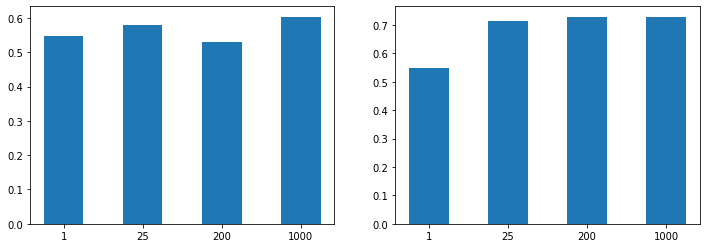

In [13]:
### YOUR CODE HERE (please, feel free to add extra cells to solve this task, after this first one ###
ks = ['1', '25', '200', '1000']
plt.figure(figsize = (12, 4))

plt.subplot(121)
plt.bar(x = ks, height = list(accs.values()), width = 0.5)

plt.subplot(122)
plt.bar(x = ks, height = list(aucs.values()), width = 0.5)

### 1.4 Please describe, interpret, compare, and discuss the obtained results (performance metric scores) of the different classifiers.
### ============  YOUR WRITTEN ANSWER HERE ============== 

<a id="section2"></a>
## 2  Experiment with KNN classifiers and demographic plus behavioral features 
----

In this section, you should:

1. Prepare a feature matrix with only `behavioral features` for each customer (one row per customer, same behavioral features included in the phone_usage.csv, charges.csv, and/or services.csv files and that you created in the previous homework) and compute a `pair-wise distance matrix` across customers, by appropriately selecting (combining) one (or more if necessary) appropriate distance measure(s).  
2. Implement a kNN classifier with hyperparameter finetuning (i.e. finetune k over an appropriate range) and feed it with the created pairwise-distance matrix (the one that refers to only behavioral features). Evaluate the kNN classifier by using a `10-fold user-stratified cross-validation` and use `Balanced Accuracy` and `AUC` as performance metrics.
3. Create a pair-wise distance matrix by appropriately combining the pair-wise distance matrices you computed for only demographic features in Task 1.1 and only behavioral features in Task 2.1. Then, again prepare a finetuned kNN classifier and feed it with the combined distance matrix to predict churn. You are asked to again evaluate it using a `10-fold user-stratified cross-validation` and `Balanced Accuracy` and `AUC` as performance metrics.  
4. Report visually `Balanced Accuracy` and `AUC` of (i) the fine-tuned kNN classifier obtained in Task 1.3 (demographic, fine-tuned), (ii) the fine-tuned kNN classifier obtained in Task 2.2 (behavioral, fine-tuned), and (iii) the fine-tuned kNN classifier obtained in Task 2.3 (demographic+behavioral, fine-tuned) in such a way that they can be easily and appropriately compared. 

<a id="section2.1"></a>
### Task 2.1

As you might be observed, demographic features do not reveal how customers actually used the services, and adding behavioral features derived from the services the customers subscribed to, the extent to which they are charged monthly, and the actual phone usage, can help in improving the performance of our classifier. Therefore, in this task, we ask you to:
- Compute a feature matrix `XB` with one row per customer and one column per **behavioral** feature (i.e., **the behavioral features that you created in homework 3**). The cell `XB[i,j]` represents the value of the behavioral feature `j` for customer `i`. The shape of the matrix `XB` should be (n_customers, n_behavioral_features). 
- Compute a pair-wise distance matrix `DB` with one row per customer and one column per customer. The cell `DB[i,j]` represents the pair-wise distance between the features vectors `XB[i]` and `XB[j]` of customer `i` and customer `j`, respectively. The shape of the matrix `DB` should be (n_customers, n_customers). Please make sure to choose an appropriate distance measure. 

One important point to be addressed here is that, depending on the different nature (e.g., numerical, categorical) of the behavioral features you created in the previous homework and you are expected to use here, selecting a single distance measure to create your pair-wise distance matrix might not be the right way to move forward. If the types of your behavioral features are very different, a more advanced strategy is needed. Specifically, you might need to use different distance measures for different subsets of your behavioral features. 
To support you with this, we provide a concrete example not related to this task for illustration. In this example, we assume that we have five features for a user: height (f1), abdomen circumference (f2), favorite three movies (f3,f4, and f5). Given these features, it is appropriate to use Euclidean distance for the vector [f1,f2] and use Jaccard distance for [f3,f4,f5]. To manage this situation, given a pair `(i, j)` of users, the following strategy can be used:
- Compute the Euclidean distance for feature vectors [f1,f2] of users i and j - we assume to denote that by `t1[i,j]`. 
- Compute the Jaccard distance for [f3,f4,f5] of users i and j - we assume to denote that by `t2[i,j]`. 
- Compute the final distance as `DB[i,j] = t1[i,j] + t2[i,j]` (do not forget to check the scaling of t1 and t2). 

In [44]:
#XB_cont = XB[['AvgMonthlyUsage', 'AvgMonthlyCharge']]
dist = DistanceMetric.get_metric('euclidean')
DB_cont = dist.pairwise(XB_cont)
DB_cont

array([[0.        , 0.54128246, 0.37264714, ..., 0.28546866, 0.40677203,
        0.45468241],
       [0.54128246, 0.        , 0.21362757, ..., 0.45931268, 0.53526293,
        0.24252229],
       [0.37264714, 0.21362757, 0.        , ..., 0.40588307, 0.5211773 ,
        0.10714737],
       ...,
       [0.28546866, 0.45931268, 0.40588307, ..., 0.        , 0.13247302,
        0.51296078],
       [0.40677203, 0.53526293, 0.5211773 , ..., 0.13247302, 0.        ,
        0.62786776],
       [0.45468241, 0.24252229, 0.10714737, ..., 0.51296078, 0.62786776,
        0.        ]])

In [42]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
scaler.fit(XB_cont)
XB_cont = scaler.transform(XB_cont)

In [43]:
XB_cont

array([[0.41000813, 0.24808443],
       [0.15274128, 0.72432016],
       [0.33515542, 0.61313643],
       ...,
       [0.12509221, 0.26584042],
       [0.00503797, 0.2098397 ],
       [0.39427949, 0.70249471]])

In [17]:
XB_cat = XB[['Contract', 'NumOfServices', 'PhoneService', 'InternetServiceValue']]
dist = DistanceMetric.get_metric('hamming')
DB_cat = dist.pairwise(XB_cat)
DB_cat

array([[0.  , 0.5 , 0.5 , ..., 0.  , 0.75, 0.5 ],
       [0.5 , 0.  , 0.25, ..., 0.5 , 1.  , 0.25],
       [0.5 , 0.25, 0.  , ..., 0.5 , 0.75, 0.  ],
       ...,
       [0.  , 0.5 , 0.5 , ..., 0.  , 0.75, 0.5 ],
       [0.75, 1.  , 0.75, ..., 0.75, 0.  , 0.75],
       [0.5 , 0.25, 0.  , ..., 0.5 , 0.75, 0.  ]])

In [28]:
DB_cont.max()

0.08296684478512929

In [29]:
### YOUR CODE HERE (please, feel free to add extra cells to solve this task, after this first one) ###

XB = contract

services_num = services.replace({'Yes' : 1, 'No' : 0, 'DSL' : 0, 'Fiber optic' : 0, 'No phone service' : 0,
       'No internet service' : 0})
services_num = services_num.groupby('ContractID').sum()
XB = XB.merge(right = services_num, on = 'ContractID', how = 'outer').rename({'ServiceValue' : 'NumOfServices'}, axis = 1)

# add average monthly usage as feature

usage_avg = phone_usage.groupby('ContractID').mean()
XB = XB.merge(right = usage_avg, on = 'ContractID', how = 'outer').rename({'MonthlyUsage' : 'AvgMonthlyUsage'}, axis = 1)

# add average monthly charges as feature

charges_avg = charges.groupby('ContractID').mean()
XB = XB.merge(right = charges_avg, on = 'ContractID', how = 'outer').rename({'Charge' : 'AvgMonthlyCharge'}, axis = 1)

# add phone service value (yes/no) as feature

phone_service = services.loc[services['Service'] == 'PhoneService']
XB = (XB.merge(right = phone_service, on = 'ContractID', how = 'outer').drop('Service', axis = 1)).rename({'ServiceValue' : 'PhoneService'}, axis = 1)

# add internet service type as feature

internet_service = services.loc[services['Service'] == 'InternetService']
XB = ((XB.merge(right = internet_service, on = 'ContractID', how = 'outer')).drop('Service', axis = 1)).rename({'ServiceValue' : 'InternetServiceValue'}, axis = 1)

In [30]:
XB = XB.drop(['ContractID', 'CustomerID', 'StartDate'], axis = 1)
XB = XB.replace({'Month-to-month' : 0, 'Two year' : 1, 'One year' : 2, 'Yes' : 1, 'No' : 0, 'DSL' : 1, 'Fiber optic' : 2})

In [16]:
DB

NameError: name 'DB' is not defined

### 2.1 Please, describe, motivate, and discuss all your design choices.

### ============  YOUR WRITTEN ANSWER HERE ============== 

<a id="section2.2"></a>
### Task 2.2

In this task, we ask you to implement a fine-tuned kNN classifier, using the pair-wise distance matrix `DB` derived from behavioral features, as an input. You can re-use and appropriately adjust the implementation you provided in task 1.3 to perform the same task but on the pair-wise distance matrix derived from demographic features. We ask you to use the again a `10-fold user-stratified cross-validation` and to compute `Balanced Accuracy` and `AUC` for this setting. No plotting is needed, it is enough to print the scores in the cell.

In [24]:
#print('unique payment methods', XB['PaymentMethod'].unique())
print('unique contract types', XB['Contract'].unique())
print('unique internet services', XB['InternetServiceValue'].unique())

XB = XB.replace({np.nan : 0})

unique contract types [0 1 2]
unique internet services [1 2 0]


In [36]:
knn = KNeighborsClassifier(n_neighbors=2, metric = 'precomputed')
knn.fit(DB, yd)

KNeighborsClassifier(metric='precomputed', n_neighbors=2)

In [37]:
### YOUR CODE HERE (please, feel free to add extra cells to solve this task, after this first one) ###
ks = np.array([5, 15, 30, 50, 100, 200, 500, 700, 1000])
yd = np.ravel(y.drop('CustomerID', axis = 1))
accs_temp = {}
aucs_temp = {}

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k, metric = 'precomputed')
    results = cross_validate(knn, DB, yd, cv=10, scoring = ['balanced_accuracy', 'roc_auc'])
    acc = results['test_balanced_accuracy'].mean()
    auc = results['test_roc_auc'].mean()
    accs_temp[acc] = k
    aucs_temp[auc] = k

In [38]:
best_acc = max(list(accs_temp.keys()))
best_k_acc = accs_temp[best_acc]
best_k_acc

5

In [39]:
best_auc = max(list(aucs_temp.keys()))
best_k_auc = aucs_temp[best_auc]
best_k_auc

5

In [41]:
aucs_temp

{0.5133125882155553: 5,
 0.5018597445070327: 15,
 0.5007368128412946: 30,
 0.4960922233229718: 50,
 0.49134537965458397: 100,
 0.49259013364108073: 200,
 0.5008264619549253: 500,
 0.49911187794979484: 700,
 0.5027825562680808: 1000}

<a id="section2.3"></a>
### Task 2.3

Once you reach this point, you have considered demographic features and behavioral features, separately. In this task, we ask you to use the pair-wise distance matrices `DD` and `DB`, obtained for only demographic features and only behavioral features respectively, to appropriately create a single pair-wise distance matrix `D` that considers both demographic and behavioral features jointly. To obtain this pair-wise distance matrix `D`, compute `D[i,j] = DD[i,j] + DB[i,j]`, for each `(i,j)` pair and do not forget to take into account the scaling of DD and DB.

Finally, we ask you to implement a fine-tuned kNN classifier, using the pair-wise distance matrix `D` as an input. You can again re-use and appropriately adjust the implementation you provided in Tasks 1.3 and 2.2 to perform the same task but on the pair-wise distance matrix `D` derived from both demographic and behavioral features. Again, you should use a `10-fold user-stratified cross-validation` and compute `Balanced Accuracy` and `AUC` for this setting. It is fine to just print the results in the cell.

In [ ]:
### YOUR CODE HERE (please, feel free to add extra cells to solve this task, after this first one) ###
raise NotImplementedError()

<a id="section2.2"></a>
### Task 2.4

Once you reach this point, you should have:
1. The fine-tuned kNN classifier obtained in Task 1.3 (demographic, fine-tuned).
2. The fine-tuned kNN classifier obtained in Task 2.2 (behavioral, fine-tuned).
3. The fine-tuned kNN classifier obtained in Task 2.3 (demographic+behavioral, fine-tuned).  

In this last task, we ask you to visually report the performance of the three above kNN classifiers. Basically, you should again properly visualize the `Balanced Accuracy` and `AUC` scores achieved by the mentioned classifiers in the 10-fold user-stratified cross validation performed in the respective tasks (Task 1.3, Task 2.2, and Task 2.3), so that the classifiers can be easily compared. 

In [ ]:
### YOUR CODE HERE (please, feel free to add extra cells to solve this task, after this first one) ###
raise NotImplementedError()

### 2.4 Please describe, interpret, compare, and discuss the obtained results (performance metric scores) of the different classifiers.

### ============  YOUR WRITTEN ANSWER HERE ============== 

## Congratulations

Congratulations! Please, carefully revise your solution and push it when you feel that it is ok. 
